<a href="https://colab.research.google.com/github/nazbeh/I_C_M_E_2020/blob/master/Workshop3/TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning Example

In this notebook we are going to train a simple "Cat" vs "Dog" classifier using transfer learning.
We are going to use the pretrained net called [MobileNet](https://arxiv.org/pdf/1704.04861.pdf) as our base model.


In [ ]:
import tensorflow as tf
import keras
import numpy as np

Using TensorFlow backend.


In [ ]:
from keras.applications import MobileNet
from keras.layers import Dense,GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing import image
from IPython.display import Image

The below line will use the Keras library to download the pretrained MobileNet model on the ImageNet database, except the last layer will be omitted.

In [ ]:
base_model=MobileNet(weights='imagenet',include_top=False)

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '
W0815 23:07:49.473351 140671525730176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0815 23:07:49.513627 140671525730176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0815 23:07:49.522211 140671525730176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.un

17227776/17225924 [==============================] - 0s 0us/step


In [ ]:
len(base_model.layers)

87

## Explore the layers of the model using model.summary()

In [ ]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)    128       
__________

## Add new layers
Since we want to perform transfer learning, we will add 4 more fully connected layers on top.
We also add a global average pooling layer to convert from convolution type outputs to inputs for fully connected layers. 

In [ ]:
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x)
x=Dense(1024,activation='relu')(x) 
x=Dense(1024,activation='relu')(x) 
x=Dense(1024,activation='relu')(x) 
preds=Dense(2,activation='softmax')(x)

We will only make the top new layers trainable the rest of them willhave their weights frozen.

In [ ]:
model=Model(inputs=base_model.input,outputs=preds)
for layer in model.layers[:87]:
    layer.trainable=False
for layer in model.layers[87:]:
    layer.trainable=True

In [ ]:
len(model.layers)

93

## Download the Dataset

Next we will download the dataset of cat and dog images.


In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O ./cats_and_dogs_filtered.zip

--2019-08-15 23:12:18--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.124.128, 2607:f8b0:4001:c05::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.124.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘./cats_and_dogs_filtered.zip’

./cats_and_dogs_fil 100%[===================>]  65.43M   232MB/s    in 0.3s    

2019-08-15 23:12:18 (232 MB/s) - ‘./cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
!ls

cats_and_dogs_filtered.zip  sample_data


Next we will unzip the dataset

In [ ]:
import os
import zipfile

local_zip = './cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./')
zip_ref.close()

In [ ]:
!ls cats_and_dogs_filtered

train  validation  vectorize.py


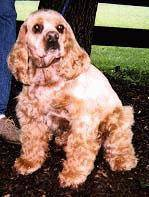

In [ ]:
Image(filename="./cats_and_dogs_filtered/train/dogs/dog.40.jpg")

## Data Generators

We can use the Keras library object ImageDataGenerator to conveniently abstract a folder of images. We will create one for the training set and one for the validation set.

In [ ]:
base_dir = './cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [ ]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) 

train_generator=train_datagen.flow_from_directory(train_dir,
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 2000 images belonging to 2 classes.


In [ ]:
val_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) 

val_generator=val_datagen.flow_from_directory(validation_dir,
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 1000 images belonging to 2 classes.


## Training the model

We will now train the model by first compiling it with an optimizer. 
Then the model's fit_generator function is called and the data generators are passed as input. The training will be run for 5 epochs.

In [ ]:
model.compile(optimizer=Adam(lr=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

step_size_train=train_generator.n//train_generator.batch_size
step_size_val=val_generator.n//val_generator.batch_size

history = model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   validation_data=val_generator,
                   validation_steps=step_size_val,
                   epochs=5)

W0815 23:16:11.378651 140671525730176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0815 23:16:11.485038 140671525730176 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5
62/62 [==============================] - 14s 225ms/step - loss: 0.2238 - acc: 0.8992 - val_loss: 0.0616 - val_acc: 0.9738
Epoch 2/5
62/62 [==============================] - 9s 144ms/step - loss: 0.1094 - acc: 0.9592 - val_loss: 0.0624 - val_acc: 0.9711
Epoch 3/5
62/62 [==============================] - 9s 142ms/step - loss: 0.0515 - acc: 0.9813 - val_loss: 0.0328 - val_acc: 0.9866
Epoch 4/5
62/62 [==============================] - 9s 140ms/step - loss: 0.0510 - acc: 0.9859 - val_loss: 0.0439 - val_acc: 0.9793
Epoch 5/5
62/62 [==============================] - 9s 139ms/step - loss: 0.0648 - acc: 0.9713 - val_loss: 0.0593 - val_acc: 0.9752


## Testing the model
Now that we have a model with decent accuracy, we can test it, by trying some example images of cats and dogs.
We will first write a function to prepare the image to be the correct format for the MobileNet input layer.

In [ ]:
def prepare_image(file):
    img_path = ''
    img = image.load_img(img_path + file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array_expanded_dims)

We can now test some images from the validation dataset

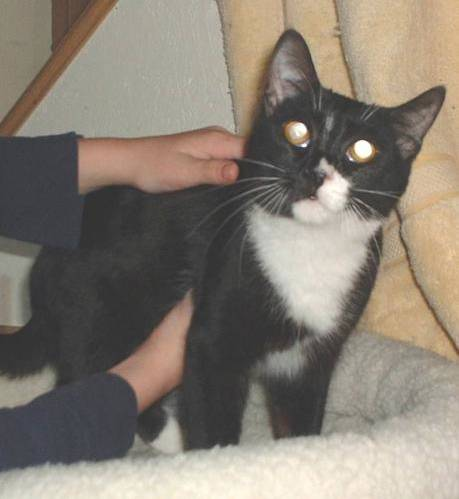

In [ ]:
Image(filename=validation_dir+"/cats/cat.2000.jpg")

In [ ]:
img = prepare_image(validation_dir+"/cats/cat.2000.jpg")
model.predict(img)

array([[9.9996471e-01, 3.5335892e-05]], dtype=float32)

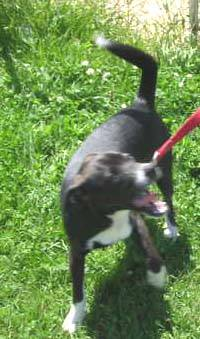

In [ ]:
Image(filename=validation_dir+"/dogs/dog.2000.jpg")

In [ ]:
img = prepare_image(validation_dir+"/dogs/dog.2003.jpg")
model.predict(img)

array([[0.00524368, 0.99475634]], dtype=float32)

The below function takes a filename and produces a clean output of what the predicted class is

In [ ]:
def predict(filen):
  img = prepare_image(filen)
  probs = model.predict(img)[0]
  pred_class = probs.argmax()
  classes = ["cat", "dog"]
  print("%s -> %.1f%% confident - %s" %(filen,probs[pred_class]*100, classes[pred_class]))

In [ ]:
predict(validation_dir+"/dogs/dog.2003.jpg")

./cats_and_dogs_filtered/validation/dogs/dog.2003.jpg -> 99.5% confident - dog


## Testing against new images
You can also test the model against images you would get from google image search. You can download a couple of images from google and run the below cell to upload and classify them. See if you can break the model.

In [ ]:
from google.colab import files
uploaded = files.upload()

for filen in uploaded.keys():
  predict(filen)

Saving cat1.jpg to cat1.jpg
Saving cat2.jpg to cat2.jpg
Saving cat3.jpg to cat3.jpg
Saving catdog.jpg to catdog.jpg
Saving dog1.jpg to dog1.jpg
Saving dog2.jpg to dog2.jpg
cat1.jpg -> 100.0% confident - cat
cat2.jpg -> 100.0% confident - cat
cat3.jpg -> 99.7% confident - cat
catdog.jpg -> 82.3% confident - dog
dog1.jpg -> 82.7% confident - dog
dog2.jpg -> 99.9% confident - dog


In [ ]:
!rm *.jpg